# Compare offline turbulence to observations
### Overview figure


In [1]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc


# -------------------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('paper')
import string
alphabet = list(string.ascii_lowercase)

# -------------------------------------------------------------------------------------------------------
# Directories
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirDataSCP = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

### Functions

In [2]:
# Group a variable according to a proxy variable (e.g., group air temperature according to the stability)
def proxyGroupby(ds, binVar, binVals, digitVar):
    proxyGroups = np.digitize(ds[binVar].values, binVals, right=False)
    groupVar = np.zeros(np.size(binVals))
    for bnum, bV in enumerate(binVals):
        groupVar[bnum] = np.nanmean(ds[digitVar][proxyGroups == bnum])
    return groupVar

### Surface observations

In [3]:
# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
SCP['w_tc__2m'] = fluxObs.w_tc__2m_M
SCP['w_tc_10m'] = fluxObs.w_tc__10m_M

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind speed magnitude
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_15m > 10] = np.nan
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_2m > 10] = np.nan

# Bulk Richardson number
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

# Indices of stable periods (simulated)
SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive


## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [4]:
os.chdir(dirProj)
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov')

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
SNQ_sensible = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
SNQ_latent = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
SCP_sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
SCP_sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
SCP_latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
SCP_latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

os.chdir(dirPrint)

# Bias by Richardson number

#### Get the mean air temperature, surface temperature, and wind speed

In [5]:
binRi = np.append(np.arange(-0.125, 0.5, 0.025), np.arange(0.5, 2, .1))
groupWind = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'UBar_2m')
groupTsfc = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'Tsfc')
groupTair = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'T_1m_M')
groupQh = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'w_tc__2m')
groupQh = -groupQh

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


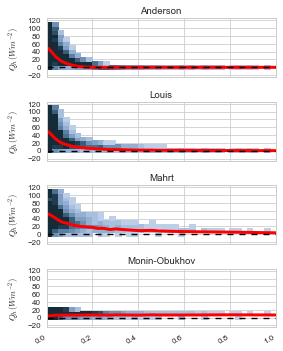

In [6]:
# -------------------------------------------------------------------------------------------------------
# Synthetic Qh set up
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov', 'Monin-Obukhov (no cap)')

# Dictionary of colors
colr = np.append(kgraph.SRON(4), sns.color_palette(["#9b59b6"]), axis=0)
colr = dict(zip(ixStabilityTitles, colr))

# Met variables
sfcTemp = groupTsfc
airTemp = groupTair
windspd = groupWind
mHeight = 2
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 0.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = np.zeros(np.size(binRi))
for n, b in enumerate(binRi):
    RiBulk[n],_,_ = turbpy.bulkRichardson(airTemp[n] + 273.15, sfcTemp[n] + 273.15, windspd[n], mHeight)
    
stabilitySchemes = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityTitles[0]: np.zeros_like(RiBulk),
    ixStabilityTitles[1]: np.zeros_like(RiBulk),
    ixStabilityTitles[2]: np.zeros_like(RiBulk),
    ixStabilityTitles[3]: np.zeros_like(RiBulk),
    }

# -------------------------------------------------------------------------------------------------------
# turbpy
for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    for n, b in enumerate(binRi):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        vp = airVaporPress[n]
        svp = sfcVaporPress[n]
        w = windspd[n]
        ts = sfcTemp[n] + 273.15
        ta = airTemp[n] + 273.15
        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(ta, airPressure, vp, w, ts, svp, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=mc.stabParams,
                                z0Ground=.005,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan
            
        if senHeatGround[stabTitle][n] < 0:
            senHeatGround[stabTitle][n] = np.nan 

# -------------------------------------------------------------------------------------------------------
# SCP observations
# Y axis
ymin = -25
ymax = 125
dy = 10
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_2m > 0.).values)
SCP_sensible_1m_plot = SCP_sensible_1m.reindex_like(SCP)

# Figure formatting
fig, axes = plt.subplots(4, 1, figsize=(4, 5), sharex='col', sharey='row')
axes = axes.flatten()

# Simulated turbulence
for (ix, stab), stabTitle in zip(enumerate(ixStability), ixStabilityTitles):
    ax = axes[ix]

    # Manual histogram
    X = SCP.RiBulk_2m.values[SCPWindex]
    Y = SCP_sensible_1m_plot[stab].values[SCPWindex]
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < dcol/2)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # Synthetic turbulence
    ax.plot(RiBulk, senHeatGround[stabTitle], color='r', linewidth=3)
    
    # Formatting
    ax.plot([xmin, xmax], [0, 0], 'k--')
    ax.set_title(stabTitle)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel('$Q_h (Wm^{-2})$')
    ax.grid()

fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('OfflineTurb.SCP_2m.2dHist_Ri.pdf', dpi=300)

Lower Ri conditions = generally higher windspeed, higher Ri = lower windspeed. So all of the curves are shifted to larger Qh at low Ri and smaller Qh at high Ri.

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive


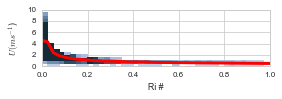

In [7]:
# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of Qh vs Ri
# Y axis
ymin = 0
ymax = 10
dy = 0.5
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_2m > 0.).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(4, 1.5))

# Manual histogram for pcolormesh
X = SCP.RiBulk_2m.values[SCPWindex]
Y = SCP.UBar_2m.values[SCPWindex]
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < dcol/2)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax, linewidth=0, rasterized=True)

# Average wind speed for Richardson number bins
ax.plot(binRi, groupWind, 'r', linewidth=3)
ax.plot([xmin, xmax], [0, 0], '--', color='0.85')

ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$U (ms^{-1}$)')
ax.grid()
fig.tight_layout()
fig.savefig('OfflineTurb.SCP_2m.2dHist_U.pdf', dpi=300)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive


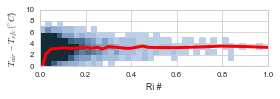

In [9]:
# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of temp. gradient vs Ri
# Y axis
ymin = 0
ymax = 10
dy = 1
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_2m > 0.).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(4, 1.5))

# Manual histogram for pcolormesh
X = SCP.RiBulk_2m.values[SCPWindex]
Y = (SCP.T_1m_M - SCP.Tsfc).values[SCPWindex]
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < dcol/2)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)

# Average temperature gradient for Richardson number bins
ax.plot(binRi, groupTair - groupTsfc, 'r', linewidth=3)
ax.plot([xmin, xmax], [0, 0], '--', color='0.85')

ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$T_{air} - T_{sfc} (^{\circ} C$)')
ax.grid()
fig.tight_layout()
fig.savefig('OfflineTurb.SCP_2m.2dHist_Tgrad.pdf', dpi=300)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive


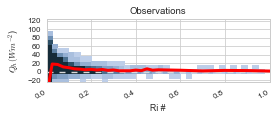

In [10]:
# -------------------------------------------------------------------------------------------------------
# SCP - 2D histogram of Qh vs Ri
# Y axis
ymin = -25
ymax = 125
dy = 10
# X axis
xmin = 0
xmax = 1
dx = .025
# Colors
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)

cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Re-filter for low wind speeds to better match with idealized synthetic results
SCPWindex = np.nonzero((SCP.RiBulk_2m > 0.).values)

# Figure formatting
fig, axes = plt.subplots(1, 1, figsize=(4, 1.5))

# Manual histogram for pcolormesh
X = SCP.RiBulk_2m.values[SCPWindex]
Y = -SCP.w_tc__2m.values[SCPWindex]
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < dcol/2)
X, Y = np.meshgrid(xedges, yedges)

# Binned observations
ax = axes
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)

# Average Qh for Richardson number bins
ax.plot([xmin, xmax], [0, 0], '--', color='0.85')
ax.plot(binRi, groupQh, 'r', linewidth=3)

ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title('Observations')
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.grid()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('OfflineTurb.SCP_2m.2dHist_Ri.ObsOnly.pdf', dpi=300)

What is the mean behavior of the wind and temperature gradient distributions?

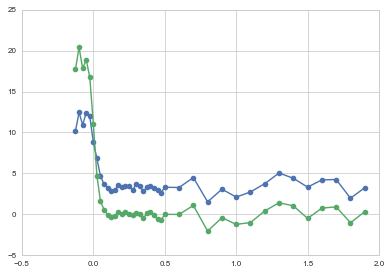

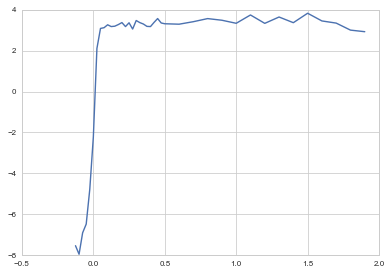

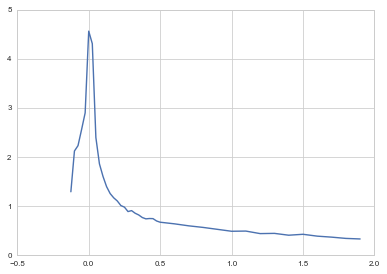

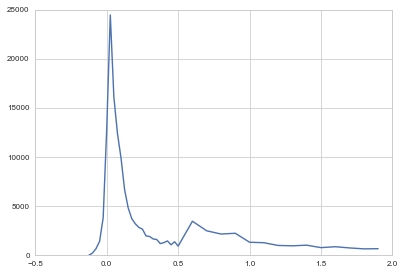

In [13]:
binRi = np.append(np.arange(-0.125, 0.5, 0.025), np.arange(0.5, 2, .1))
groupWind = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'UBar_2m')
groupTsfc = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'Tsfc')
groupTair = proxyGroupby(SCP, 'RiBulk_2m', binRi, 'T_1m_M')

plt.figure()
plt.plot(binRi, groupTair, '-o')
plt.plot(binRi, groupTsfc, '-o')

plt.figure()
plt.plot(binRi, groupTair - groupTsfc)

plt.figure()
plt.plot(binRi, groupWind)

groupRi = np.digitize(SCP['RiBulk_2m'].values, binRi, right=False)
numObs = np.zeros(np.size(binRi))
for bnum, bV in enumerate(binRi):
    numObs[bnum] = np.nansum(groupRi[groupRi == bnum])
plt.figure()
plt.plot(binRi, numObs)

### Mean Qh

In [11]:
print(SNQ.SensFlux[SNQind].mean(dim='time'))
print(-SCP.w_tc_10m[SCPind].mean(dim='time'))
print(-SCP.w_tc__2m[SCPind].mean(dim='time'))

<xarray.DataArray 'SensFlux' ()>
array(3.2573252857412203)
<xarray.DataArray 'w_tc_10m' ()>
array(8.77803941295555)
Coordinates:
    altitude   float64 1.645e+03
    station    |S3 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81
<xarray.DataArray 'w_tc__2m' ()>
array(12.321427601635806)
Coordinates:
    altitude   float64 1.645e+03
    station    |S3 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81
